In [1]:
!pip install empyrical

    100% |████████████████████████████████| 51kB 19.1MB/s ta 0:00:01
    100% |████████████████████████████████| 112kB 24.0MB/s ta 0:00:01
  Running setup.py bdist_wheel for empyrical ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/10/a4/3b/951bd609878a82fd72b9ea23699daf1eaada4ff6f583152876
Successfully built empyrical
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install pyfolio

    100% |████████████████████████████████| 92kB 21.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for pyfolio ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/0d/a8/7d/ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
Successfully built pyfolio
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [50]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import empyrical as ep
import pyfolio as pf
from collections import OrderedDict
from IPython.display import display, HTML
%matplotlib inline

def symbol_to_path(symbol, base_dir="AdjDaily"):
    """Return CSV file path given ticker symbol."""
    return os.path.join(base_dir, "{}.csv".format(str(symbol)))

def get_data(symbols, dates,col):
    """Read stock data (adjusted close) for given symbols from CSV files."""
    df = pd.DataFrame(index=dates)
    if 'TASI' not in symbols:  # add SPY for reference, if absent
        symbols.insert(0, 'TASI')
    dateparse = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol), index_col='Date',
                parse_dates=['Date'],date_parser=dateparse, usecols=['Date', col ], na_values=['nan'])
        df_temp = df_temp.rename(columns={col: symbol})
        df = df.join(df_temp)

        if symbol == 'TASI':  # drop dates SPY did not trad
            df = df.dropna(subset=["TASI"])

    return df

def load_df():
    dates = pd.date_range('01/01/2002', '01/01/2017')
    N= (dates[-1]-dates[0])/365
    N = str(N).split()[0]
    files = os.listdir("AdjDaily")
    symbols=[]
    for name in files:
        if name[0].isdigit():
            symbols.append(name.split('.')[0])
    df = get_data(symbols, dates, 'Close')
    df.to_pickle('database.pkl')
    return df
def normalize_data(df):
    return df/df.iloc[0,:]

def compute_daily_returns(df):
    daily_returns = (df/df.shift(1))-1
    daily_returns = daily_returns[1:]
    return daily_returns

def stats(df,period):
    if period == 'W':
        p = 52.0
    if period == 'M':
        p = 12.0
    if period == 'D':
        p = 365.0
    cagr = (df.iloc[-1]/df.iloc[0])**(1.0/(len(df)/p)) - 1.0
    dr = compute_daily_returns(df)
    sharpe = np.sqrt(p) * dr.mean() / dr.std()
    print (' CAGR(%) = ' + str(cagr * 100))
    print (' Sharpe ratio = ' + str(sharpe))

def multi_period_return(period_returns):
    return np.prod(period_returns + 1) - 1

def pos_val(df,capital=100000,alloc=[]):
    if alloc == []:
        alloc= 1.0/len(df.columns)
    return (normalize_data(df) * alloc * capital).sum(axis=1)

# This function creates chunks and returns them
def chunkify(lst,n):
    return [ lst[i::n] for i in np.arange(n) ]

def portfolio(df,holdPeriod,capital=100000):
    if isinstance(df,pd.DataFrame):
#         capital = df.shape[1] * 1000
        alloc = 1 / df.shape[1]
    else:
#         capital = 1000
        alloc = 1 
    postions = norm(df[:holdPeriod+1]) * alloc * capital * 0.99845 # Trading Commissions
    if isinstance(df,pd.DataFrame):
        portfolio = postions.sum(axis=1)
    else:
        portfolio = postions
    return portfolio

def norm(df):
    if isinstance(df,pd.DataFrame):
        mask = df.iloc[0].isnull()
        df = df.loc[:,~mask]
        mask = df.iloc[0]==0
        df = df.loc[:,~mask]
    df = df / df.iloc[0]
    return df

# https://github.com/quantopian/pyfolio/blob/13af662b5c3851ede1f1910bf3c3acfca3b53c52/pyfolio/utils.py#L170
def print_table(table,
                name=None,
                float_format=None,
                formatters=None,
                header_rows=None):
    """
    Pretty print a pandas DataFrame.
    Uses HTML output if running inside Jupyter Notebook, otherwise
    formatted text output.
    Parameters
    ----------
    table : pandas.Series or pandas.DataFrame
        Table to pretty-print.
    name : str, optional
        Table name to display in upper left corner.
    float_format : function, optional
        Formatter to use for displaying table elements, passed as the
        `float_format` arg to pd.Dataframe.to_html.
        E.g. `'{0:.2%}'.format` for displaying 100 as '100.00%'.
    formatters : list or dict, optional
        Formatters to use by column, passed as the `formatters` arg to
        pd.Dataframe.to_html.
    header_rows : dict, optional
        Extra rows to display at the top of the table.
    """

    if isinstance(table, pd.Series):
        table = pd.DataFrame(table)

    if name is not None:
        table.columns.name = name

    html = table.to_html(float_format=float_format, formatters=formatters)

    if header_rows is not None:
        # Count the number of columns for the text to span
        n_cols = html.split('<thead>')[1].split('</thead>')[0].count('<th>')

        # Generate the HTML for the extra rows
        rows = ''
        for name, value in header_rows.items():
            rows += ('\n    <tr style="text-align: right;"><th>%s</th>' +
                     '<td colspan=%d>%s</td></tr>') % (name, n_cols, value)

        # Inject the new HTML
        html = html.replace('<thead>', '<thead>' + rows)
    display(HTML(html))
    
percentage_formatter = '{:.2%}'.format
float_formatter = '{:.2f}'.format

In [51]:
sb.set()
sb.set_color_codes("deep")
# Change the default figure size
# https://stackabuse.com/python-data-visualization-with-matplotlib/
fig_size = plt.rcParams["figure.figsize"]  
fig_size[0] = 20  
fig_size[1] = 10  
plt.rcParams["figure.figsize"] = fig_size 

In [81]:
data = pd.read_pickle('AdjustedClose.pkl')

In [82]:
df = data.xs(slice('01/01/2010','30/09/2019'),level=1,drop_level=False)
df.head()

Industry Group Company Name   Open   High    Low  Close  \
Symbol Date                                                                 
1010   2010-01-02          Banks   Riyad Bank  13.45  13.45  13.25  13.30   
       2010-01-03          Banks   Riyad Bank  13.30  13.35  13.15  13.35   
       2010-01-04          Banks   Riyad Bank  13.25  13.45  13.15  13.45   
       2010-01-05          Banks   Riyad Bank  13.45  13.55  13.40  13.50   
       2010-01-06          Banks   Riyad Bank  13.45  13.50  13.40  13.50   

                   Volume Traded  split         F  AdjClose  
Symbol Date                                                  
1010   2010-01-02         229088    2.0  1.641748  8.101122  
       2010-01-03         233586    2.0  1.641748  8.131577  
       2010-01-04         359380    2.0  1.641748  8.192488  
       2010-01-05         768392    2.0  1.641748  8.222943  
       2010-01-06         432196    2.0  1.641748  8.222943

In [83]:
bh = df[['AdjClose']].unstack(level=0)
bh = bh.droplevel(0,1)
df = df[['Close']].unstack(level=0)
# returns = df.resample('BM').mean()
df = df.droplevel(0,1)
# returns = returns.droplevel(0,1)
# df = df.dropna(subset=["TASI"])
# tasi = df['TASI'].copy()
# df = df.drop('TASI',axis=1)

returns = compute_daily_returns(df)

In [10]:
returns.tail()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-24,0.028133,0.002928,0.006452,NaN,-0.002890,0.011309,0.006167,0.021053,0.012882,0.003802,...,0.018085,0.011111,0.007080,0.017900,0.009101,0.017007,0.020431,0.009434,-0.004283,0.015929
2019-09-25,0.013267,-0.008759,-0.006410,NaN,-0.034783,-0.031949,-0.004378,-0.027491,-0.003180,0.000000,...,0.009404,-0.002536,-0.008787,-0.003517,-0.007892,-0.005017,-0.014461,-0.007477,-0.002151,-0.005226
2019-09-26,-0.004092,-0.007364,0.000000,NaN,-0.009009,-0.008251,-0.002639,-0.005300,0.004785,0.005682,...,-0.011387,-0.002542,-0.014184,-0.017647,0.007955,-0.015126,-0.006772,-0.005650,-0.004310,0.007005
2019-09-29,0.007395,0.001484,0.002581,NaN,-0.003030,0.014975,0.025573,0.008881,-0.001587,-0.001883,...,0.023037,0.011045,0.012590,0.099401,0.001127,0.011945,0.009091,0.009470,0.005411,0.017391
2019-09-30,-0.004894,0.001481,0.014157,NaN,-0.019757,-0.001639,0.031814,0.007042,0.006359,0.000000,...,0.003071,0.036134,0.008881,0.062092,0.019144,0.005059,0.016892,0.001876,0.003229,0.005128


In [11]:
lookback = 8
holdPeriod = 3
mom = returns.rolling(lookback).apply(multi_period_return)
mom = mom[lookback:]
mom.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  app.launch_new_instance()


Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-13,-0.026217,-0.049652,0.006481,0.004571,-0.002881,-0.063839,0.014177,0.063325,0.024718,-0.029412,...,-0.013630,-0.051715,NaN,NaN,-0.048354,NaN,NaN,NaN,NaN,NaN
2010-01-16,0.033457,-0.040594,0.022748,0.036405,0.027652,0.003153,0.061614,0.080940,0.038677,-0.045510,...,-0.022342,-0.048607,NaN,NaN,-0.017470,NaN,NaN,NaN,NaN,NaN
2010-01-17,0.096296,-0.038729,0.026388,0.002195,0.033333,0.050446,0.032017,0.081633,0.027996,-0.045679,...,0.009259,-0.019830,NaN,NaN,0.011963,NaN,NaN,NaN,NaN,NaN
2010-01-18,0.092593,-0.038845,0.019108,0.009751,0.032826,0.084234,0.035088,0.070707,0.034938,-0.062500,...,-0.004404,-0.029725,NaN,NaN,0.041376,NaN,NaN,NaN,NaN,NaN
2010-01-19,0.081784,-0.054455,0.010870,-0.020170,0.029762,0.044385,0.000000,0.041565,0.017229,-0.068881,...,-0.052632,-0.039423,NaN,NaN,0.017628,NaN,NaN,NaN,NaN,NaN


In [13]:
mask = mom.iloc[0].isnull()
hold = mom.loc[:,~mask]
hold.tail()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8170,8180,8190,8200,8210,8220,8230,8240,8250,8280
Date,,,,,,,,,,,,,,,,,,,,,
2019-09-24,-0.023482,1.331361e-02,5.154639e-03,NaN,0.036036,-3.184713e-03,0.019643,0.056261,0.057143,0.086420,...,-0.023460,-0.010246,-0.012141,-2.220446e-16,0.068136,NaN,0.004717,-0.026450,-4.440892e-16,-0.004489
2019-09-25,0.007420,8.915305e-03,1.291990e-03,NaN,0.001504,-1.623377e-02,0.025248,0.040441,0.050251,0.078431,...,-0.024890,-0.018349,-0.012249,-1.639344e-02,0.059406,NaN,0.017433,-0.017294,-8.403361e-03,-0.014558
2019-09-26,0.003298,5.970149e-03,-3.330669e-16,NaN,-0.006024,2.220446e-16,0.030909,0.050373,0.067797,0.083673,...,0.006070,-0.005181,0.000000,-1.543550e-02,0.041257,NaN,0.007812,-0.010363,-6.751055e-03,0.009101
2019-09-29,0.024227,-3.330669e-16,2.580645e-03,NaN,-0.051873,1.666667e-02,0.051537,0.023423,0.051839,0.060000,...,0.010574,0.010373,0.003409,-1.733478e-02,0.013359,NaN,0.039062,0.027340,1.276596e-02,-0.001125
2019-09-30,0.058109,-5.882353e-03,1.025641e-02,NaN,-0.058394,1.500000e-02,0.081081,0.030631,0.055000,0.068548,...,0.050305,0.023810,0.013746,1.439646e-02,0.015267,NaN,0.059748,0.021898,2.750000e-02,0.016854


In [67]:
porto = hold.sort_values(by=hold.index.values[0], ascending=False, axis=1)
porto.head()

Symbol,8260,2170,2220,2002,6070,2020,6002,5110,4200,8010,...,8090,2110,8040,8120,8150,8100,8230,4300,8140,8180
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-31,0.667684,0.523321,0.453295,0.359603,0.318831,0.315917,0.287334,0.275616,0.254353,0.249949,...,-0.257129,-0.263018,-0.265924,-0.274078,-0.276144,-0.281028,-0.282961,-0.299874,-0.467043,-0.655077
2011-02-28,0.675379,0.590250,0.544917,0.420117,0.327959,0.419984,0.167714,0.089335,0.161162,0.243085,...,-0.190999,-0.253212,-0.201682,-0.233942,-0.144018,-0.140694,-0.220794,-0.302636,-0.458782,-0.640120
2011-03-31,-0.060996,0.587661,0.283247,0.432384,0.204882,0.337345,0.020315,0.005204,-0.078088,0.123057,...,-0.331577,-0.253140,-0.296756,-0.356383,-0.259813,-0.240135,-0.315817,-0.263944,-0.549263,-0.659034
2011-04-30,0.024638,0.433745,0.281574,0.444987,0.090553,0.287424,0.036617,-0.028028,-0.020629,0.169551,...,0.017334,-0.010770,0.008708,-0.149505,0.020809,-0.024410,0.154840,-0.172837,-0.382843,-0.363041
2011-05-31,-0.055457,0.347535,0.389450,0.359273,0.113817,0.237151,0.071254,-0.020656,-0.018381,0.089255,...,0.070074,0.046155,0.068789,-0.038208,0.109252,0.053343,0.294282,-0.160420,-0.395468,0.012525


In [68]:
tickers = np.array(porto.columns)
tickers

array([8260, 2170, 2220, 2002, 6070, 2020, 6002, 5110, 4200, 8010, 2060,
       2330, 1211, 1030, 4001, 2070, 2150, 2040, 6060, 4290, 4150, 2280,
       4240, 1214, 2310, 2010, 6050, 7020, 6001, 4020, 2130, 2290, 4070,
       3020, 4002, 2210, 1212, 7010, 3060, 4050, 3080, 1090, 4100, 8030,
       2230, 2120, 2190, 1120, 3090, 2001, 3030, 1050, 6020, 4280, 1020,
       2250, 6010, 2160, 6090, 4260, 2270, 2350, 1140, 4190, 8170, 2200,
       4090, 2360, 4040, 1210, 2180, 4230, 2260, 4010, 8210, 1010, 1040,
       2140, 2050, 3050, 1150, 2300, 1080, 4080, 2080, 1060, 7040, 3010,
       4180, 2090, 4030, 4250, 7030, 3040, 8190, 4140, 4270, 1310, 8280,
       4210, 2100, 2340, 1213, 2030, 8160, 8200, 8270, 4061, 8020, 2320,
       8250, 1320, 8220, 4110, 6040, 8070, 4220, 8130, 8240, 4170, 4160,
       2240, 8080, 4130, 8050, 2380, 2370, 8060, 8110, 8090, 2110, 8040,
       8120, 8150, 8100, 8230, 4300, 8140, 8180])

In [102]:
for array in chunkify(tickers,10):
    print(len(array))

19
19
19
19
19
18
18
18
18
18


In [69]:
# https://stackoverflow.com/questions/13148429/how-to-change-the-order-of-dataframe-columns
quartiles = df.loc[hold.index.values[0]:]
quartiles = quartiles[tickers[:10]]
quartiles.head()

Symbol,8260,2170,2220,2002,6070,2020,6002,5110,4200,8010
Date,,,,,,,,,,
2011-01-31,46.0,19.15,27.0,21.25,23.85,102.0,34.69,13.80,18.67,39.60
2011-02-01,45.7,19.95,26.8,21.35,23.85,103.2,34.44,13.80,18.67,39.76
2011-02-02,45.9,20.80,27.3,22.20,24.10,106.8,35.08,14.00,18.73,40.80
2011-02-05,46.5,20.80,26.8,22.65,24.15,106.0,36.35,14.05,18.87,41.20
2011-02-06,46.3,21.20,26.9,22.75,24.60,107.4,37.76,14.05,19.07,41.20


In [19]:
test = portfolio(quartiles,holdPeriod)

In [74]:
def portfolio(df,capital=100000):
    if isinstance(df,pd.DataFrame):
#         capital = df.shape[1] * 1000
        alloc = 1 / df.shape[1]
    else:
#         capital = 1000
        alloc = 1 
    postions = norm(df) * alloc * capital
    if isinstance(df,pd.DataFrame):
        portfolio = postions.sum(axis=1)
    else:
        portfolio = postions
    return portfolio

portfolio(quartiles)[:holdPeriod*30+1]

Date
2011-01-31    100000.000000
2011-02-01    100411.506149
2011-02-02    102565.978929
2011-02-05    103243.854555
2011-02-06    104332.864507
2011-02-07    105411.327712
2011-02-08    104985.893865
2011-02-09    105205.999030
2011-02-12    106652.028938
2011-02-13    106476.808461
2011-02-14    105659.956599
2011-02-15    106026.009371
2011-02-16    104370.186346
2011-02-19    102314.603033
2011-02-20    102956.948179
2011-02-21    102852.903557
2011-02-22    102775.469232
2011-02-23    101942.248532
2011-02-27     97175.874133
2011-02-28     96491.917285
2011-03-01     89526.412164
2011-03-02     87231.189241
2011-03-05     91948.598935
2011-03-06     91490.889176
2011-03-07     92439.893262
2011-03-08     94067.068997
2011-03-09     93824.320628
2011-03-12     98041.185645
2011-03-13     96818.548175
2011-03-14     95417.850364
                  ...      
2011-04-30     98922.434204
2011-05-01     98775.905719
2011-05-02     99649.805765
2011-05-03     99274.482519
2011-05-04     

In [20]:
test.values

array([100000.        ,  99201.87711226, 102285.7345602 , 104498.59773043,
       100627.3367267 ,  93311.73432478, 105933.00063014, 112114.29513365,
       109404.34848989, 106867.86046184])

In [21]:
test.index.values

array(['2010-10-31T00:00:00.000000000', '2010-11-30T00:00:00.000000000',
       '2010-12-31T00:00:00.000000000', '2011-01-31T00:00:00.000000000',
       '2011-02-28T00:00:00.000000000', '2011-03-31T00:00:00.000000000',
       '2011-04-30T00:00:00.000000000', '2011-05-31T00:00:00.000000000',
       '2011-06-30T00:00:00.000000000', '2011-07-31T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [73]:
i=2
hold = mom[holdPeriod*i:]
mask = hold.iloc[0].isnull()
hold = hold.loc[:,~mask]
hold.head()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8220,8230,8240,8250,8260,8270,8280,8290,8300,8310
Date,,,,,,,,,,,,,,,,,,,,,
2011-04-30,-0.037486,0.163468,0.113304,-0.076806,0.092433,0.028958,0.136161,-0.067194,-0.015081,-0.001176,...,0.049940,0.154840,0.012263,0.577134,0.024638,-0.006909,0.103715,0.552100,-0.028095,1.146698
2011-05-31,-0.085994,0.113766,0.049451,-0.120165,0.005627,-0.040754,0.021689,-0.141867,-0.038561,-0.014987,...,0.141169,0.294282,0.155510,0.904044,-0.055457,0.079749,0.138886,0.442662,0.050445,1.384447
2011-06-30,-0.115254,0.119522,0.031646,-0.094828,-0.057194,-0.027967,0.015863,-0.178141,-0.051404,-0.007128,...,0.186929,0.179502,0.115967,1.148620,-0.202926,0.053018,0.052330,0.258654,0.014394,1.733101
2011-07-31,-0.069846,0.121999,0.053161,-0.051234,-0.038788,0.043682,0.039080,-0.179565,-0.050449,0.007808,...,0.198747,0.139071,0.145004,1.528717,-0.261340,0.051794,0.053185,0.191854,0.024756,1.759216
2011-08-31,-0.086238,-0.004843,0.017331,-0.093967,-0.057422,0.060169,0.020933,-0.238057,-0.129087,-0.056578,...,0.122724,-0.022132,-0.044319,1.889661,-0.311543,-0.090962,-0.065092,-0.026681,-0.077553,1.350780


In [50]:
# Last value = New Capital for next cycle
new = portfolio(quartiles,holdPeriod)[-1]
portfolio(quartiles[holdPeriod*1:],holdPeriod,new)

Date
2003-03-31    102807.613941
2003-04-30    113015.262904
2003-05-31    122443.105772
2003-06-30    133275.321421
Freq: M, dtype: float64

In [57]:
from collections import defaultdict
# Working Loop for one decile
# Loop
lookbacks = [2,5,8,11]
lookbacks = [x*21 for x in lookbacks]
holdPeriods = [1,3,6,9]
holdPeriods =[x*21 for x in holdPeriods]
returns = compute_daily_returns(df)
with pd.ExcelWriter('results-daily.xlsx') as writer:
    for lookback in lookbacks:
        for holdPeriod in holdPeriods:
            print(lookback,holdPeriod)
            mom = returns.rolling(lookback).apply(multi_period_return)
            mom = mom[lookback:]
            epochs = int(np.floor(mom.shape[0]/(holdPeriod)))
            newCapital = 100000
            deciles = defaultdict(dict)
            # deciles = pd.DataFrame(columns=['Decile1','Decile2','Decile3','Decile4'])
            for i in range(0,epochs):
                # First loop 
                if i == 0:
                    mask = mom.iloc[0].isnull()
                    hold = mom.loc[:,~mask]
                else:
                    hold = mom[holdPeriod*i:]
                    mask = hold.iloc[0].isnull()
                    hold = hold.loc[:,~mask]
                porto = hold.sort_values(by=hold.index.values[0], ascending=False, axis=1)
                tickers = np.array(porto.columns)
                prices = df.loc[hold.index.values[0]:]
                prices = prices[tickers]
                chunks = chunkify(prices.T,5)    
                for j in range(0,len(chunks)):
                    name = 'Q'+str(j+1)
                    if i == 0:
                        # If first loop use 100k as starting capital, else use the capital from last trade
                        newCapital = 100000.0
                    else:
                        newCapital = list(deciles[name].values())[-1]
                    q = chunks[j].T
                    port = portfolio(q,holdPeriod,newCapital)
                    port.rename(name,inplace=True)
                    for index, row in port.iteritems():
                        deciles[name].update({index:row})                
            final = pd.DataFrame(deciles)
            fdr = compute_daily_returns(final)
            stats = pd.concat(OrderedDict([(a,perf_stats(fdr[a])) for a in fdr.columns]), axis=1)
            sheet_name = str(lookback)+','+str(holdPeriod)
            stats.to_excel(writer,sheet_name=sheet_name)

42 21


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


42 63


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


42 126


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


42 189


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


105 21


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


105 63


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


105 126


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


105 189


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


168 21


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


168 63


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


168 126


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


168 189


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


231 21


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


231 63


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


231 126


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


231 189


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning


In [23]:
ep.aggregate_returns(compute_daily_returns(final),'yearly') 

,Q1,Q2,Q3,Q4,Q5
2010,-0.108578,-0.066358,-0.151337,-0.117664,0.017229
2011,0.149167,0.283390,0.160558,0.226431,0.191383
2012,0.148217,0.207775,0.289353,0.053673,0.013530
2013,0.311848,0.222125,0.211014,0.095872,0.119969
2014,-0.002717,0.057478,-0.025705,-0.038903,-0.064622
2015,-0.112924,-0.093621,-0.170060,-0.203941,-0.221045
2016,-0.046413,0.010013,-0.058546,-0.008958,-0.008197
2017,-0.039554,-0.024710,-0.113662,-0.105346,-0.027942
2018,-0.054127,-0.032228,-0.072004,-0.085535,-0.056121
2019,0.001798,0.003402,-0.033019,0.019383,0.029312


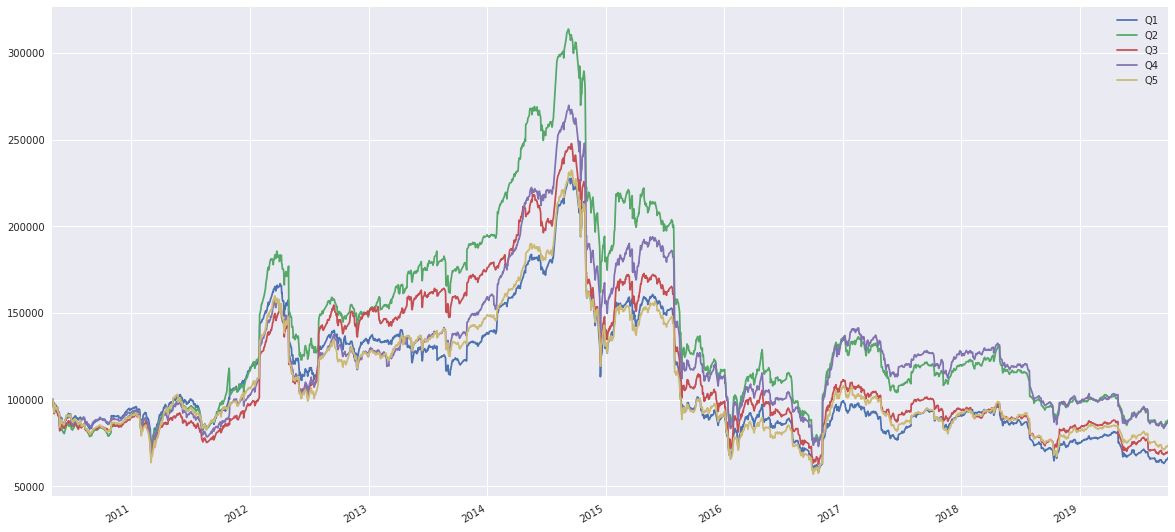

In [80]:
final.plot()

In [102]:
SIMPLE_STAT_FUNCS = [
    ep.cum_returns_final,
    ep.stability_of_timeseries,
    ep.max_drawdown,
    ep.tail_ratio,
]

PERIOD_STAT_FUNCS = [
    ep.annual_return,
    ep.annual_volatility,
    ep.sharpe_ratio,
    ep.calmar_ratio,
    ep.sortino_ratio,
]

FACTOR_STAT_FUNCS = [
    ep.alpha,
    ep.beta,
]

STAT_FUNC_NAMES = {
    'annual_return': 'Annual return',
    'cum_returns_final': 'Cumulative returns',
    'annual_volatility': 'Annual volatility',
    'sharpe_ratio': 'Sharpe ratio',
    'calmar_ratio': 'Calmar ratio',
    'stability_of_timeseries': 'Stability',
    'max_drawdown': 'Max drawdown',
    'sortino_ratio': 'Sortino ratio',
    'tail_ratio': 'Tail ratio',
}

STAT_FUNCS_PCT = [
    'Annual return',
    'Cumulative returns',
    'Annual volatility',
    'Max drawdown',
]
def perf_stats(returns, factor_returns=None, positions=None,
               transactions=None, turnover_denom='AGB',period='daily'):
    """
    Calculates various performance metrics of a strategy, for use in
    plotting.show_perf_stats.
    Parameters
    ----------
    returns : pd.Series
        Daily returns of the strategy, noncumulative.
         - See full explanation in tears.create_full_tear_sheet.
    factor_returns : pd.Series, optional
        Daily noncumulative returns of the benchmark factor to which betas are
        computed. Usually a benchmark such as market returns.
         - This is in the same style as returns.
         - If None, do not compute alpha, beta, and information ratio.
    positions : pd.DataFrame
        Daily net position values.
         - See full explanation in tears.create_full_tear_sheet.
    transactions : pd.DataFrame
        Prices and amounts of executed trades. One row per trade.
        - See full explanation in tears.create_full_tear_sheet.
    turnover_denom : str
        Either AGB or portfolio_value, default AGB.
        - See full explanation in txn.get_turnover.
    Returns
    -------
    pd.Series
        Performance metrics.
    """

    stats = pd.Series()
    for stat_func in PERIOD_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns,period=period)    
    for stat_func in SIMPLE_STAT_FUNCS:
        stats[STAT_FUNC_NAMES[stat_func.__name__]] = stat_func(returns)
    for stat, value in stats.iteritems():
        if stat in STAT_FUNCS_PCT:
            stats[stat] = str(np.round(value * 100,2)) + '%'

    if positions is not None:
        stats['Gross leverage'] = gross_lev(positions).mean()
        if transactions is not None:
            stats['Daily turnover'] = get_turnover(positions,
                                                   transactions,
                                                   turnover_denom).mean()
    if factor_returns is not None:
        for stat_func in FACTOR_STAT_FUNCS:
            res = stat_func(returns, factor_returns)
            stats[STAT_FUNC_NAMES[stat_func.__name__]] = res

    return stats


In [26]:
fdr = compute_daily_returns(final)
stats = pd.concat(OrderedDict([(a,perf_stats(fdr[a])) for a in fdr.columns]), axis=1)
print_table(stats,float_format=float_formatter)

,Q1,Q2,Q3,Q4,Q5
Annual return,1.78%,5.16%,-0.74%,-2.42%,-0.65%
Annual volatility,20.19%,19.34%,19.53%,19.92%,19.93%
Sharpe ratio,0.19,0.36,0.06,-0.02,0.07
Calmar ratio,0.03,0.10,-0.01,-0.04,-0.01
Sortino ratio,0.24,0.46,0.08,-0.03,0.09
Cumulative returns,18.47%,62.16%,-6.88%,-20.99%,-6.12%
Stability,0.14,0.38,0.00,0.14,0.13
Max drawdown,-53.91%,-52.9%,-62.21%,-60.44%,-59.1%
Tail ratio,0.91,0.91,0.86,0.88,0.88


In [38]:
# monthly prices
fdr = compute_daily_returns(final)
stats = pd.concat(OrderedDict([(a,perf_stats(fdr[a],period='monthly')) for a in fdr.columns]), axis=1)
stats.to_excel('test.xlsx')
# print_table(stats,float_format=float_formatter)

In [21]:
def bench(df,capital=100000):
    if isinstance(df,pd.DataFrame):
#         capital = df.shape[1] * 1000
        alloc = 1 / df.shape[1]
    else:
#         capital = 1000
        alloc = 1 
    postions = norm(df) * alloc * capital
    if isinstance(df,pd.DataFrame):
        portfolio = postions.sum(axis=1)
    else:
        portfolio = postions
    return portfolio
benchs = bench(bh)

In [24]:
pf.show_perf_stats(compute_daily_returns(benchs))

Start date,2010-01-03
End date,2019-09-30
Total months,115
,Backtest
Annual return,1.9%
Cumulative returns,20.2%
Annual volatility,18.1%
Sharpe ratio,0.20
Calmar ratio,0.04
Stability,0.25
Max drawdown,-50.8%


Having tested multiple combinations of momentum stratgeis, it doesn't seem there is a perfect stratgey that i could utilize. I have read about TSMOM and i should try to backtest it in TASI. But i didn't see a straight forward way to do it.

In [14]:
try:
    df = pd.read_pickle('AdjustedClose.pkl')
except:
    print ('No pkl')
    df = load_df()
df = df.xs(slice('01/01/2010','30/09/2017'),level=1,drop_level=False)
bh = df[['AdjClose']].unstack(level=0)
bh = bh.droplevel(0,1)
df = df[['Close']].unstack(level=0)
# returns = df.resample('BM').mean()
df = df.droplevel(0,1)
# returns = returns.droplevel(0,1)

# returns = compute_daily_returns(df)

In [78]:
lookback = 252
holdPeriod = 252
returns = np.log(df/df.shift(1))[1:]
mask = returns.iloc[0].isnull()
hold = returns.loc[:,~mask]
hold = hold[:lookback]
# Calculate the t-statistics as
# (mean-0)/(stdev/sqrt(n)), where n is sample size
mean = np.mean(hold)
std = np.std(hold)
n = len(hold)
t_stat = mean/(std/np.sqrt(n))

# cap holding at 1 and -1
# t_stat = np.clip(t_stat, a_max=1, a_min=0)
t_stat = t_stat[t_stat > 0]
tickers = t_stat[t_stat > 0].sort_values(ascending=False)
tickers = np.array(tickers.index)

# postions = norm(returns) * alloc * 100
# postions.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


In [147]:
from collections import defaultdict
# Working Loop for one decile
# Loop
def log_returns(df):
    return np.log(df[-1]/df[0])

holdPeriod = 21
lookback = 252
# returns = df.rolling(lookback).apply(log_returns) # Calaculte the rolling CAGR for each stock
# returns = returns[lookback:]
returns = np.log(df/df.shift(1))[1:]
epochs = int((np.floor(returns.shape[0]-lookback+1)/(holdPeriod)))
print(epochs)
newCapital = 100000
deciles = defaultdict(dict)
for i in range(0,epochs):
    # First loop 
    if i == 0:
        mask = returns.iloc[0].isnull()
        hold = returns.loc[:,~mask]
        hold = hold[:lookback]
    else:
        x = (lookback)+(holdPeriod * i)
        hold = returns[:x]
        mask = hold.iloc[0].isnull()
        hold = hold.loc[:,~mask]
    mean = np.mean(hold)
    std = np.std(hold)
    n = len(hold)
    t_stat = mean/(std/np.sqrt(n))    
    tickers = t_stat[t_stat > 1.5].sort_values(ascending=False)
    tickers = np.array(tickers.index)
    prices = df[df.index.get_loc(hold.index.values[-1])+1:]
    print(tickers)
    if i == 0:
    # If first loop use 100k as starting capital, else use the capital from last trade
        newCapital = 100000.0
    else:
        if len(deciles) != 0:
            newCapital = list(deciles.values())[-1]
        else:
            newCapital = 100000.0
    if len(tickers) != 0:
        prices = prices[tickers]
    #     print(np.array(prices.columns))
        port = portfolio(prices,holdPeriod,newCapital)
        for index, row in port.iteritems():
            deciles.update({index:row})                
    else:
        pass
print(newCapital)
final = pd.Series(deciles)
fdr = compute_daily_returns(final)
# stats = pd.concat(OrderedDict([(a,perf_stats(fdr[a])) for a in fdr.columns]), axis=1)
# sheet_name = str(lookback)+','+str(holdPeriod)
# stats.to_excel(writer,sheet_name=sheet_name)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in log


79
[2280]
[4001 2020]
[]
[4001]
[4001]
[4001 3030 2130]
[4001 3030 2060 2020]
[4001]
[4070 4001]
[4070 4001 3030]
[4070 4001 6090 3030]
[4070 6090 4001 3030 4190 6060]
[3030 4150 6020 4001 4070 6090]
[3030 2130 6020 4070]
[3030 2130 4150 6020 4070 4190 4040 4090 4100 3050 1211 3020 4001 4110]
[3030 2130 4070 4150 4190 6020 1211 4040 4240 4090]
[3030 4070 4150 4240 4190 4040 4090 4110 6020 2130]
[3030 4070 4190 4240]
[3030 4070 4100 4150 4240 4190]
[3030 4070 4110 4240 4190 4100]
[3030 4070 4240 4110 4190 4100]
[3030 4070 4240 4110 4190]
[3030 4240 4110 4070 4190]
[3030 4240 4110 4070 4190]
[3030 4240 4110 4070 4190]
[3030 4240 4070 4110 4190]
[4240 3030 4110 4070 4190 3060 4100]
[4070 4240 3030 4190 4090 4110 4100 3060 4170]
[4240 3030 4100 4190 3060 4090 4070]
[4100 4240 3030 4190 4090 3060 4001 4070]
[4240 4100 3030 4190 4090 4001 3060 4070]
[4240 4190 4100 3030 4090 3060 4001 4070 4150 4040 2270]
[4240 4190 4100 3030 4001 4090 3060 4040 4070]
[4240 4190 3030 4100 4090 4001 3060 4040

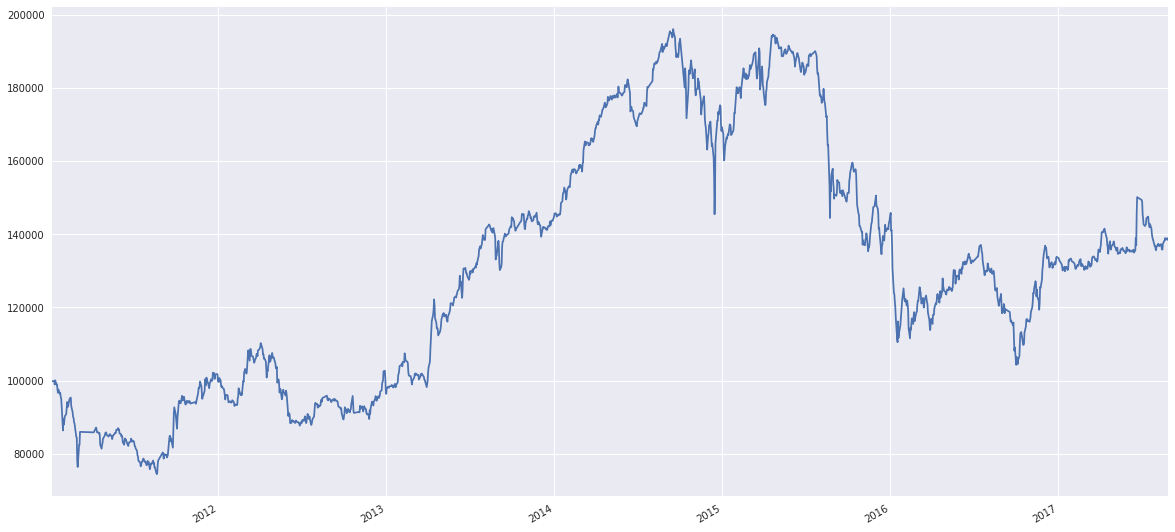

In [148]:
final.plot()

Start date,2011-01-08
End date,2017-08-28
Total months,78
,Backtest
Annual return,5.2%
Cumulative returns,38.6%
Annual volatility,20.4%
Sharpe ratio,0.35
Calmar ratio,0.11
Stability,0.37
Max drawdown,-46.8%


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,46.81,2014-09-17,2016-10-02,NaT,NaN
1,25.65,2011-01-12,2011-08-21,2011-12-04,233
2,20.46,2012-04-03,2012-06-27,2013-04-08,265
3,8.93,2011-12-21,2012-02-06,2012-02-27,49
4,8.75,2013-08-13,2013-09-05,2013-10-01,36


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


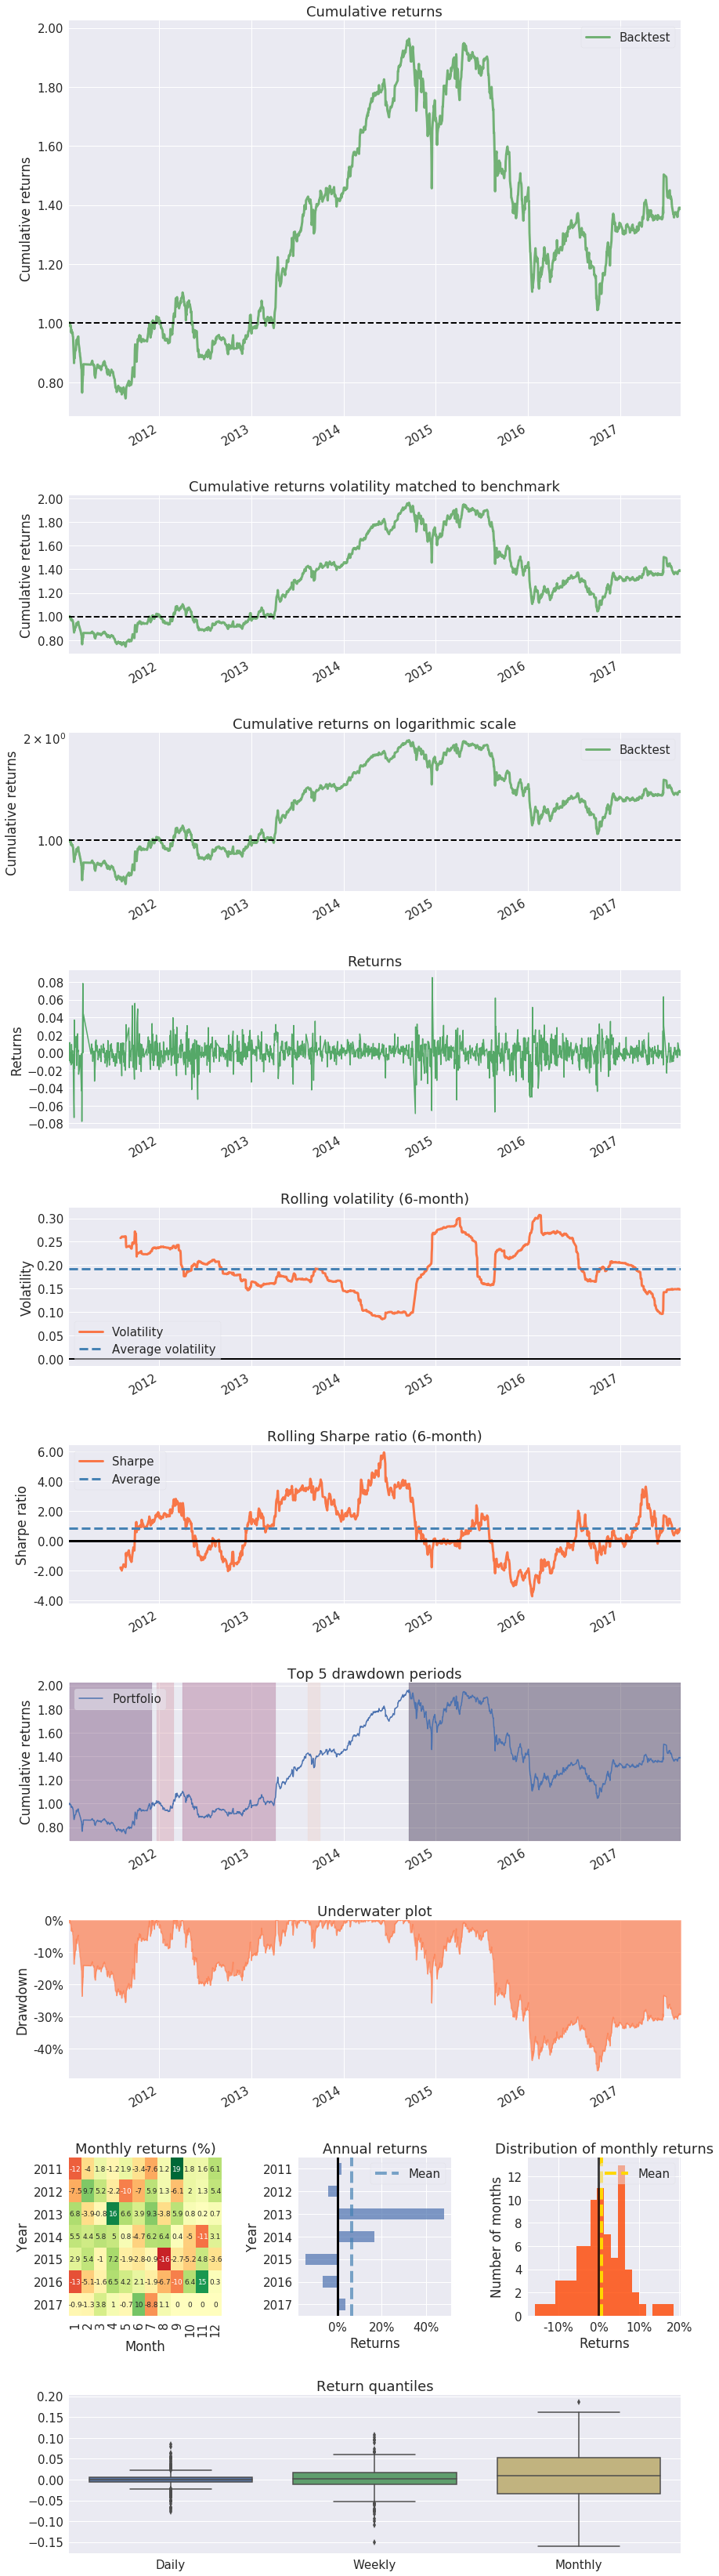

In [149]:
pf.create_returns_tear_sheet(fdr)

In [136]:
from collections import defaultdict
def log_returns(df):
    return np.log(df[-1]/df[0])
# Working Loop for one decile
# Loop
lookbacks = [21,42,63,252]
# lookbacks = [x*21 for x in lookbacks]
holdPeriods = [5,10,21,42]
# holdPeriods =[x*21 for x in holdPeriods]
with pd.ExcelWriter('tstat-HighFreq.xlsx') as writer:
    for lookback in lookbacks:
        for holdPeriod in holdPeriods:
            print(lookback,holdPeriod)
            returns = np.log(df/df.shift(1))[1:]
#             returns = returns[lookback:]
            epochs = int((np.floor(returns.shape[0]-lookback+1)/(holdPeriod)))
            newCapital = 100000
            deciles = defaultdict(dict)
            for i in range(0,epochs):
                # First loop 
                if i == 0:
                    mask = returns.iloc[0].isnull()
                    hold = returns.loc[:,~mask]
                    hold = hold[:lookback]
                else:
                    x = (lookback)+(holdPeriod * i)
                    hold = returns[:x]
                    mask = hold.iloc[0].isnull()
                    hold = hold.loc[:,~mask]
                mean = np.mean(hold)
                std = np.std(hold)
                n = len(hold)
                t_stat = mean/(std/np.sqrt(n))    
                tickers = t_stat.sort_values(ascending=False)
                tickers = np.array(tickers.index)
                prices = df[df.index.get_loc(hold.index.values[-1])+1:]
                prices = prices[tickers]
                chunks = chunkify(prices.T,5)    
                for j in range(0,len(chunks)):
                    name = 'Q'+str(j+1)
                    if i == 0:
                        # If first loop use 100k as starting capital, else use the capital from last trade
                        newCapital = 100000.0
                    else:
                        newCapital = list(deciles[name].values())[-1]
                    q = chunks[j].T
                    port = portfolio(q,holdPeriod,newCapital)
                    port.rename(name,inplace=True)
                    for index, row in port.iteritems():
                        deciles[name].update({index:row})                
            final = pd.DataFrame(deciles)
            fdr = compute_daily_returns(final)
            stats = pd.concat(OrderedDict([(a,perf_stats(fdr[a])) for a in fdr.columns]), axis=1)
            sheet_name = str(lookback)+','+str(holdPeriod)
            stats.to_excel(writer,sheet_name=sheet_name)

21 5


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:14: RuntimeWarning: divide by zero encountered in log


21 10
21 21
21 42
42 5
42 10
42 21
42 42
63 5
63 10
63 21
63 42
252 5
252 10
252 21
252 42


In [62]:
stats.head()

,Q1,Q2,Q3,Q4,Q5
Annual return,26.08%,15.96%,16.56%,13.25%,15.43%
Annual volatility,22.09%,20.44%,19.59%,19.06%,19.42%
Sharpe ratio,1.16069,0.827601,0.880992,0.748838,0.836568
Calmar ratio,0.752957,0.362906,0.364283,0.316886,0.417407
Sortino ratio,1.62901,1.12382,1.19477,1.02976,1.14253


In [8]:
from scipy.stats import linregress
def momentum(closes):
    returns = np.log(closes)
    x = np.arange(len(returns))
    slope, _, rvalue, _, _ = linregress(x, returns)
    return ((1 + slope) ** 252) * (rvalue ** 2)  # annualize slope and multiply by R^2

In [141]:
holdPeriod = 21
lookback = 126
returns = df.rolling(lookback).apply(momentum, raw=False)
returns = returns[lookback:]
returns.head()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-27,0.004860,0.370260,0.536888,0.571122,0.183903,0.184591,0.124024,0.121545,0.253549,0.244018,...,0.329574,0.316418,NaN,NaN,0.371141,NaN,NaN,NaN,NaN,NaN
2010-06-28,0.002571,0.368999,0.539046,0.542895,0.160058,0.206661,0.140300,0.103208,0.225270,0.257379,...,0.329344,0.316240,NaN,NaN,0.371148,NaN,NaN,NaN,NaN,NaN
2010-06-29,0.000687,0.368365,0.547035,0.516001,0.127008,0.228835,0.161029,0.083472,0.194561,0.270777,...,0.327944,0.315143,NaN,NaN,0.371378,NaN,NaN,NaN,NaN,NaN
2010-06-30,0.000007,0.368467,0.552767,0.487074,0.104932,0.249551,0.177387,0.067288,0.164784,0.281849,...,0.325674,0.312816,NaN,NaN,0.371620,NaN,NaN,NaN,NaN,NaN
2010-07-03,0.000699,0.369816,0.559874,0.463520,0.083591,0.273785,0.194293,0.051458,0.138104,0.294065,...,0.323706,0.310993,NaN,NaN,0.371913,NaN,NaN,NaN,NaN,NaN


In [138]:
lookback = 126
returns = compute_daily_returns(df)
returns = returns.rolling(lookback).apply(multi_period_return)
returns = returns[lookback:]
returns.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  app.launch_new_instance()


Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2010-06-28,0.074906,-0.110228,0.088889,0.088000,0.092593,-0.011856,-0.014722,0.153034,0.088277,6.127451e-03,...,-0.320301,-0.310289,NaN,NaN,-0.248971,NaN,NaN,NaN,NaN,NaN
2010-06-29,0.044610,-0.120792,0.063694,0.085324,0.052414,-0.048198,-0.040349,0.120104,0.059646,1.353014e-02,...,-0.356757,-0.348443,NaN,NaN,-0.241398,NaN,NaN,NaN,NaN,NaN
2010-06-30,0.040741,-0.123138,0.059145,0.040615,0.042169,-0.062500,-0.067769,0.091837,0.045118,1.358025e-02,...,-0.357407,-0.356374,NaN,NaN,-0.250680,NaN,NaN,NaN,NaN,NaN
2010-07-03,0.025926,-0.131474,0.063694,0.027086,0.030024,-0.084234,-0.085593,0.065657,0.048589,-9.992007e-16,...,-0.361468,-0.354459,NaN,NaN,-0.206341,NaN,NaN,NaN,NaN,NaN
2010-07-04,0.022305,-0.144554,0.054348,-0.030786,0.023810,-0.103418,-0.123267,0.009780,0.031013,-3.690037e-03,...,-0.377193,-0.357579,NaN,NaN,-0.228632,NaN,NaN,NaN,NaN,NaN


In [152]:
from collections import defaultdict
holdPeriod = 252
epochs = int((np.floor(returns.shape[0])/(holdPeriod)))
print(epochs)
newCapital = 100000
deciles = defaultdict(dict)
for i in range(0,epochs):
    # First loop 
    if i == 0:
        mask = returns.iloc[0].isnull()
        hold = returns.loc[:,~mask]
        hold = hold[:holdPeriod]
        h = holdPeriod
    else:
        h = (holdPeriod * i)
        hold = returns[h:holdPeriod*(i+1)]
        mask = hold.iloc[0].isnull()
        hold = hold.loc[:,~mask]  
    tickers = hold.max().sort_values(ascending=False).index
    tickers = np.array(tickers)
    prices = df[df.index.get_loc(hold.index.values[0]):]
    prices = prices[:h]
    prices = prices[tickers]
    chunks = chunkify(prices.T,5)    
    for j in range(0,len(chunks)):
        name = 'Q'+str(j+1)
        if i == 0:
            # If first loop use 100k as starting capital, else use the capital from last trade
            newCapital = 100000.0
        else:
            newCapital = list(deciles[name].values())[-1]
        q = chunks[j].T
        port = portfolio(q,holdPeriod,newCapital)
        port.rename(name,inplace=True)
        for index, row in port.iteritems():
            deciles[name].update({index:row}) 
print(newCapital)
final = pd.DataFrame(deciles)
fdr = compute_daily_returns(final)
stats = pd.concat(OrderedDict([(a,perf_stats(fdr[a])) for a in fdr.columns]), axis=1)

9
112678.08537027209


In [153]:
stats.head(20)

,Q1,Q2,Q3,Q4,Q5
Annual return,-0.23%,1.77%,3.45%,-0.74%,1.26%
Annual volatility,20.48%,20.01%,20.04%,19.86%,19.72%
Sharpe ratio,0.0924747,0.188985,0.270631,0.0630131,0.163454
Calmar ratio,-0.00391843,0.0294048,0.0611672,-0.0127121,0.020461
Sortino ratio,0.118742,0.23919,0.345792,0.0802145,0.206214
Cumulative returns,-2.01%,17.11%,35.69%,-6.46%,11.94%
Stability,0.0442852,0.00637785,0.190662,0.0463818,0.0042105
Max drawdown,-57.57%,-60.22%,-56.4%,-58.19%,-61.63%
Tail ratio,0.905987,0.882433,0.888388,0.907904,0.868532


In [191]:
holdPeriod = 21
lookback = 90
returns = df.rolling(lookback).apply(momentum, raw=False)
returns = returns[lookback:]
returns.head()

Symbol,1010,1020,1030,1040,1050,1060,1080,1090,1120,1140,...,8240,8250,8260,8270,8280,8290,8300,8310,8311,8312
Date,,,,,,,,,,,,,,,,,,,,,
2010-05-08,0.479099,0.034200,0.137143,0.733410,0.987019,0.121694,0.331492,1.109524,1.333719,0.551034,...,0.404408,0.470980,NaN,NaN,0.423843,NaN,NaN,NaN,NaN,NaN
2010-05-09,0.442276,0.038461,0.135898,0.688741,0.954921,0.079583,0.305919,1.066138,1.302913,0.563036,...,0.398868,0.460254,NaN,NaN,0.422279,NaN,NaN,NaN,NaN,NaN
2010-05-10,0.410808,0.039355,0.151362,0.657986,0.917079,0.051308,0.285946,1.023298,1.276822,0.582586,...,0.396062,0.455797,NaN,NaN,0.423075,NaN,NaN,NaN,NaN,NaN
2010-05-11,0.380672,0.040420,0.164980,0.630950,0.889871,0.031449,0.270686,0.966834,1.241766,0.599540,...,0.394355,0.454976,NaN,NaN,0.425802,NaN,NaN,NaN,NaN,NaN
2010-05-12,0.348018,0.041675,0.176502,0.619250,0.866735,0.016432,0.254840,0.907595,1.205536,0.625117,...,0.392926,0.455049,NaN,NaN,0.425122,NaN,NaN,NaN,NaN,NaN


In [248]:
x = returns

In [259]:
from collections import defaultdict
holdPeriod = 30
returns = x[1000:]
epochs = int((np.floor(returns.shape[0])/(holdPeriod)))
print(epochs)
newCapital = 100000
deciles = defaultdict(dict)
for i in range(0,epochs):
    # First loop 
    if i == 0:
        mask = returns.iloc[0].isnull()
        hold = returns.loc[:,~mask]
        hold = hold[:holdPeriod]
        h = holdPeriod
    else:
        h = (holdPeriod * i)
        hold = returns[h:holdPeriod*(i+1)]
        mask = hold.iloc[0].isnull()
        hold = hold.loc[:,~mask]  
    tickers = hold.max().sort_values(ascending=False)
    tickers = tickers[tickers > 7].index
    print(tickers)
    prices = df[df.index.get_loc(hold.index.values[0]):]
    if i == 0:
    # If first loop use 100k as starting capital, else use the capital from last trade
        newCapital = 100000.0
    else:
        if len(deciles) != 0:
            newCapital = list(deciles.values())[-1]
            
        else:
            pass
    print(newCapital)
    if len(tickers) != 0:
        print('Hold Stocks')
        prices = prices[tickers]
    #     print(np.array(prices.columns))
        port = portfolio(prices,holdPeriod,newCapital)
        for index, row in port.iteritems():
            deciles.update({index:row})                
    else:
        print('Go Cash')
        prices = prices[:holdPeriod]
        port = pd.Series(index=prices.index,data=[newCapital]*len(prices.index))
        for index, row in port.iteritems():
            deciles.update({index:row})     
print(newCapital)
final = pd.Series(deciles)
fdr = compute_daily_returns(final)

44
Int64Index([4160, 4070, 2100, 8280, 2300], dtype='int64', name='Symbol')
100000.0
Hold Stocks
Int64Index([2100, 8280], dtype='int64', name='Symbol')
82982.03994944136
Hold Stocks
Int64Index([], dtype='int64', name='Symbol')
83351.06362331967
Go Cash
Int64Index([8030], dtype='int64', name='Symbol')
83351.06362331967
Hold Stocks
Int64Index([8030], dtype='int64', name='Symbol')
99677.65835279011
Hold Stocks
Int64Index([], dtype='int64', name='Symbol')
63789.385891983315
Go Cash
Int64Index([], dtype='int64', name='Symbol')
63789.385891983315
Go Cash
Int64Index([], dtype='int64', name='Symbol')
63789.385891983315
Go Cash
Int64Index([], dtype='int64', name='Symbol')
63789.385891983315
Go Cash
Int64Index([], dtype='int64', name='Symbol')
63789.385891983315
Go Cash
Int64Index([], dtype='int64', name='Symbol')
63789.385891983315
Go Cash
Int64Index([], dtype='int64', name='Symbol')
63789.385891983315
Go Cash
Int64Index([4210], dtype='int64', name='Symbol')
63789.385891983315
Hold Stocks
Int64

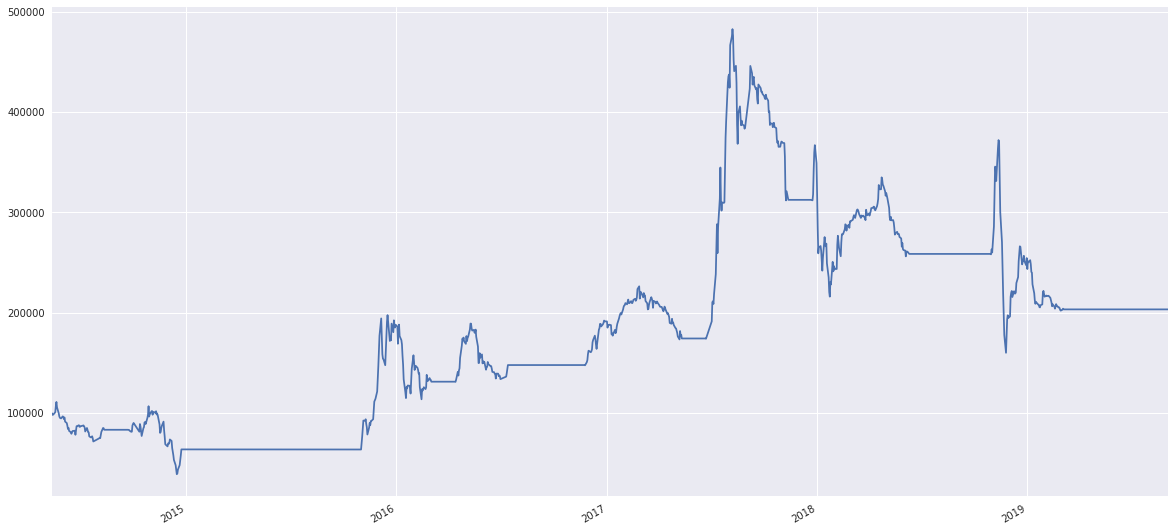

In [260]:
final.plot()

Start date,2014-05-14
End date,2019-09-02
Total months,62
,Backtest
Annual return,14.6%
Cumulative returns,103.7%
Annual volatility,48.5%
Sharpe ratio,0.52
Calmar ratio,0.22
Stability,0.66
Max drawdown,-66.8%


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,66.84,2017-08-07,2018-11-25,NaT,NaN
1,64.84,2014-05-21,2014-12-16,2015-11-24,395
2,42.47,2015-12-17,2016-02-14,2017-01-24,289
3,24.01,2015-12-06,2015-12-13,2015-12-17,9
4,23.39,2017-02-26,2017-05-07,2017-07-09,95


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


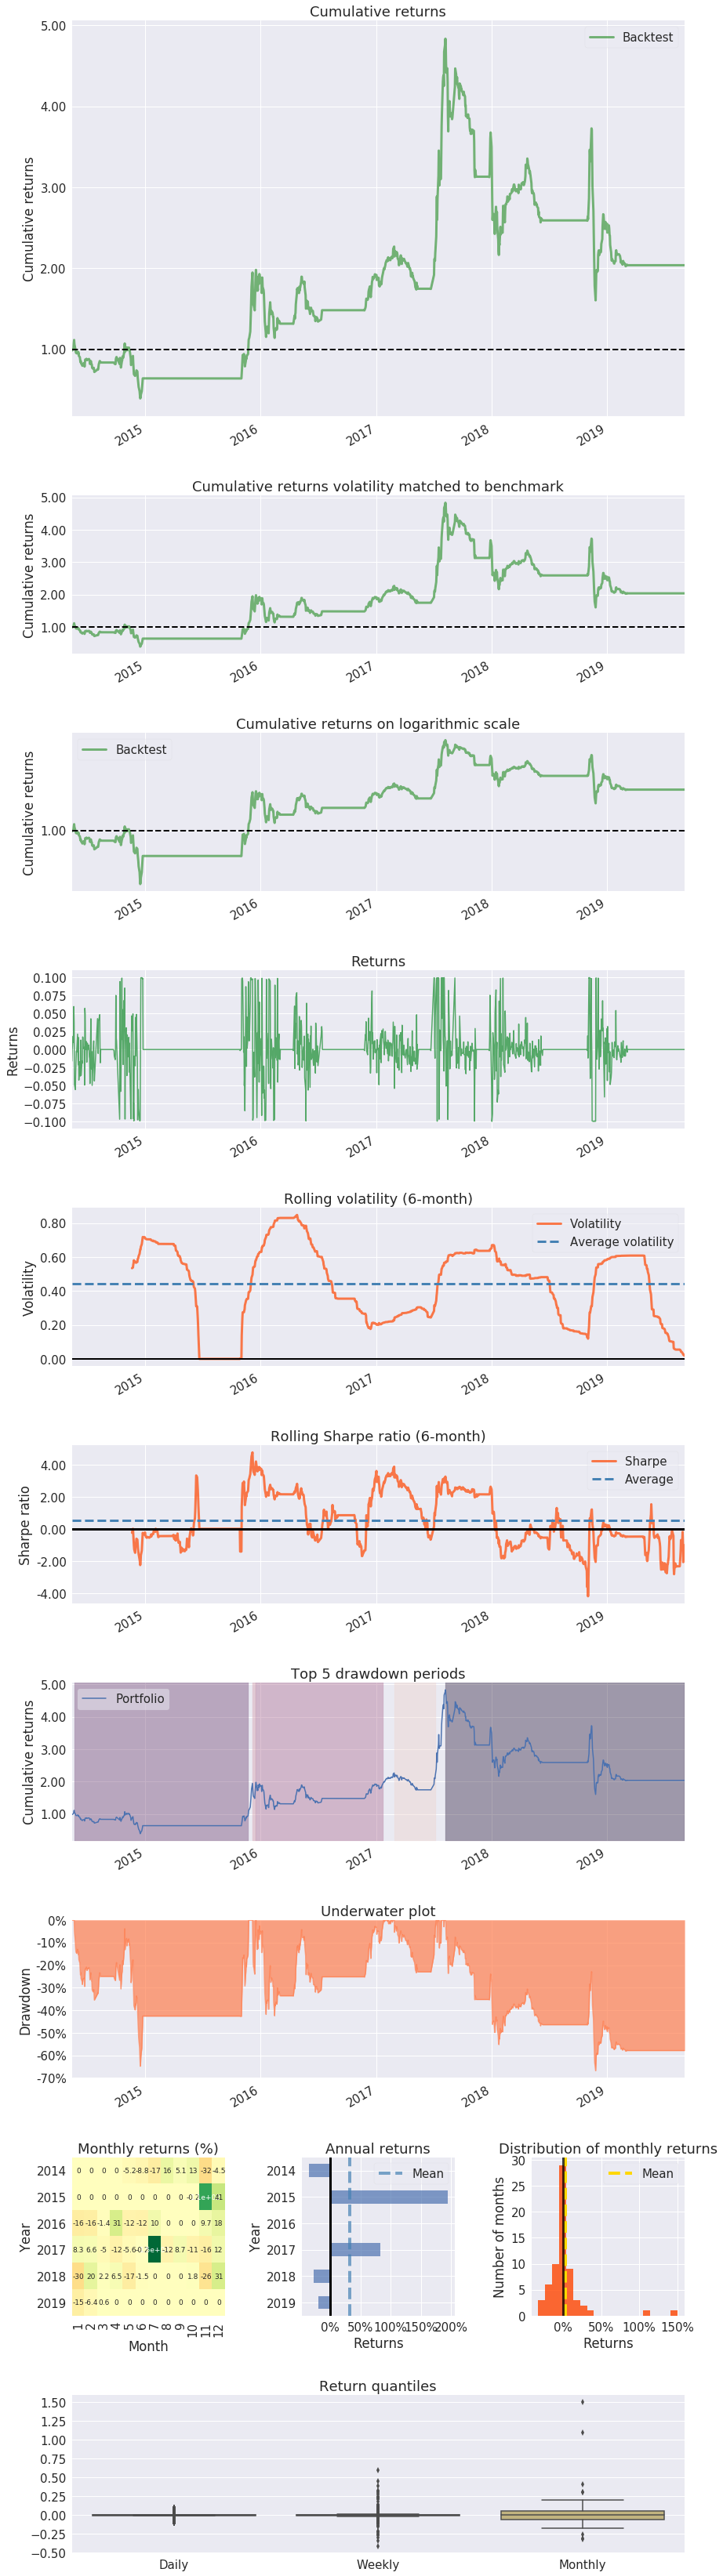

In [261]:
pf.create_returns_tear_sheet(fdr)